In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Input
from tensorflow.keras.callbacks import ReduceLROnPlateau
import seaborn as sns
from pylab import rcParams
# Step 1: 讀取數據
data = pd.read_csv('Trina, 10.5kW, mono-Si, Dual, 2009_23-24_data_5min.csv')
data = data[data[(data['timestamp']=='2023-11-02 00:00:00')].index.to_list()[0]:data[(data['timestamp']=='2023-12-07 01:25:00')].index.to_list()[0]]
data.pop('wind_speed')
data['timestamp'] = pd.to_datetime(data['timestamp'])

# 填充缺失值
data = data.interpolate(method='linear')  # 填充缺失值
print("Missing value check:")
print(data.isna().sum())

# 確認數據範圍
print("Original data range:", data['timestamp'].min(), "to", data['timestamp'].max())


Missing value check:
timestamp          0
power              0
rainfall           0
temperature        0
solar_radiation    0
dtype: int64
Original data range: 2023-11-02 00:00:00 to 2023-12-07 01:20:00


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 288 to 10287
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   timestamp        10000 non-null  datetime64[ns]
 1   power            10000 non-null  float64       
 2   rainfall         10000 non-null  float64       
 3   temperature      10000 non-null  float64       
 4   solar_radiation  10000 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 390.8 KB


In [21]:
# Step 2: 數據正規化與特徵工程
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data.drop(columns=['timestamp']))

# 增加平滑處理，避免數據波動過大
smoothed_data = pd.DataFrame(scaled_data).rolling(window=5, min_periods=1).mean().values

In [22]:
# Step 3: 創建 LSTM 訓練數據集
time_step = 10  # 增加時間步長，學習更長期依賴
X, y = [], []

for i in range(time_step, len(smoothed_data)):
    X.append(smoothed_data[i - time_step:i])
    y.append(smoothed_data[i, 0])  # 使用第 1 列作為目標值

X, y = np.array(X), np.array(y)


In [23]:
print(X.shape)

(9990, 10, 4)


In [24]:
print(y.shape)

(9990,)


In [25]:
# Step 4: 調整 train_size
#train_size = data[data['timestamp'] < '2023-11-02'].shape[0] - time_step
train_size = 8000
# 劃分訓練集和測試集
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 重新生成 timestamps_test
timestamps_test = data['timestamp'][time_step + train_size:].reset_index(drop=True)
print("Adjusted Timestamps_test range:", timestamps_test.min(), "to", timestamps_test.max())

# Step 5: 定義改進後的 LSTM 模型
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),  # 使用 Input 層定義輸入形狀
    Bidirectional(LSTM(units=64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(units=64, return_sequences=True)),
    Dropout(0.3),
    LSTM(units=64, return_sequences=False),
    Dropout(0.3),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')




Adjusted Timestamps_test range: 2023-11-30 03:30:00 to 2023-12-07 01:20:00


In [26]:
data[data['timestamp'] < '2023-11-02'].shape[0]

0

In [27]:
train_size

8000

In [28]:
X_train.shape

(8000, 10, 4)

In [29]:
# Step 6: 訓練 LSTM 模型，記錄訓練歷史，並添加驗證集
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-10)

print("Training LSTM model...")
history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=32, 
    verbose=1, 
    validation_split=0.2,  # 使用 20% 的訓練數據作為驗證集
    callbacks=[lr_scheduler]
)


Training LSTM model...
Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0129 - val_loss: 0.0025 - learning_rate: 0.0010
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0032 - val_loss: 0.0024 - learning_rate: 0.0010
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0023 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0022 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0022 - val_loss: 0.0028 - learning_rate: 0.0010
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0021 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0019 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0019 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 9/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0016 - val_loss: 0.0011 - learning

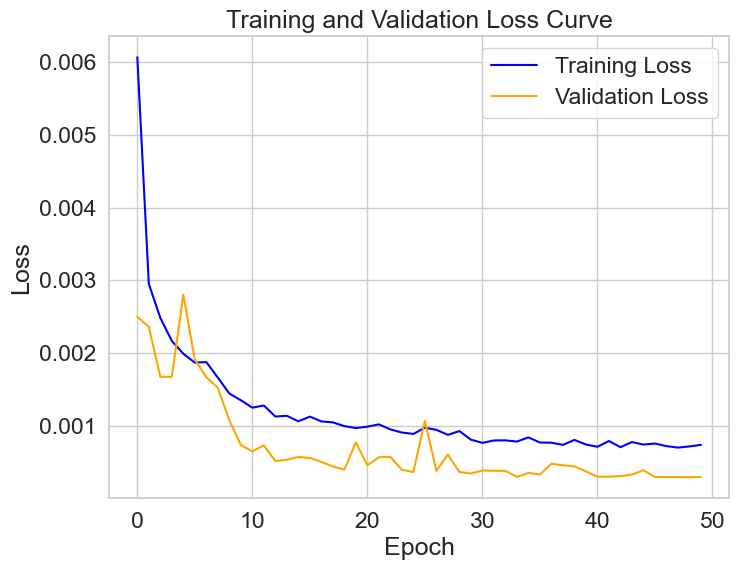

In [30]:
# Step 7：繪製訓練和驗證損失曲線
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [31]:
# Step 8: 使用測試集進行預測
print("Predicting on test data...")
y_pred3 = model.predict(X_test)

# 將預測值反歸一化，並將小於 0 的值設為 0
y_pred_rescaled = scaler.inverse_transform(
    np.concatenate((y_pred3, np.zeros((y_pred3.shape[0], scaled_data.shape[1] - 1))), axis=1)
)[:, 0]
y_pred_rescaled = np.maximum(y_pred_rescaled, 0)  # 確保預測值 >= 0

# 將實際值反歸一化
y_test_rescaled = scaler.inverse_transform(
    np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], scaled_data.shape[1] - 1))), axis=1)
)[:, 0]


Predicting on test data...
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


Adjusted plot range: 2023-11-30 03:30:00 to 2023-12-07 01:20:00


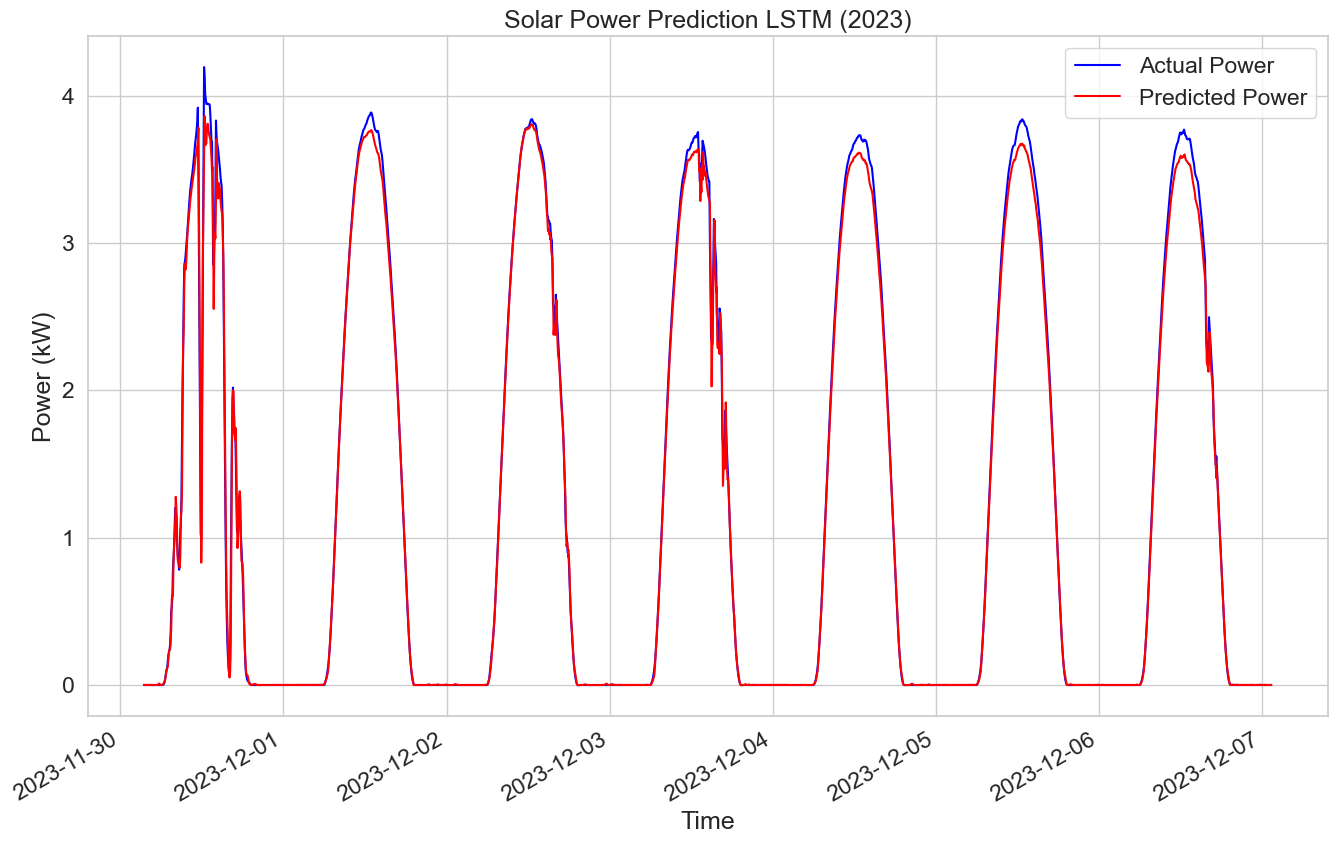

In [32]:
sns.set_theme(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 16, 10
#  最後: 繪圖
plot_start_time = pd.to_datetime("2023-11-30 00:00")
plot_end_time = pd.to_datetime("2023-12-07 01:20")

# 動態調整繪圖範圍
plot_start_time = max(plot_start_time, timestamps_test.min())
plot_end_time = min(plot_end_time, timestamps_test.max())

if plot_start_time >= plot_end_time:
    print("Adjusted plot range is invalid! No overlapping data!")
else:
    print(f"Adjusted plot range: {plot_start_time} to {plot_end_time}")

    # 篩選數據進行繪圖
    timestamps_test_plot = timestamps_test[(timestamps_test >= plot_start_time) & (timestamps_test <= plot_end_time)]
    y_test_plot = y_test_rescaled[:len(timestamps_test_plot)]
    y_pred_plot = y_pred_rescaled[:len(timestamps_test_plot)]

    if len(timestamps_test_plot) > 0:
        # 繪圖
        
        plt.plot(timestamps_test_plot, y_test_plot, color='blue', label='Actual Power')
        plt.plot(timestamps_test_plot, y_pred_plot, color='red', linestyle='-', label='Predicted Power')
        plt.title('Solar Power Prediction LSTM (2023)')
        plt.xlabel('Time')
        plt.ylabel('Power (kW)')
        plt.legend()
        plt.gcf().autofmt_xdate()
        plt.show()
    else:
        print("No data available in the specified range!")


In [33]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test_plot,y_pred_plot)

np.float64(0.005682294419563741)

In [34]:
y_pred_plot

array([0.00218507, 0.        , 0.        , ..., 0.        , 0.00037483,
       0.00124528])

In [35]:
result=pd.DataFrame(y_pred_plot,columns=['power_lstm'],index=timestamps_test_plot[-1990:])
result

,power_lstm
timestamp,
2023-11-30 03:30:00,0.002185
2023-11-30 03:35:00,0.000000
2023-11-30 03:40:00,0.000000
2023-11-30 03:45:00,0.000000
2023-11-30 03:50:00,0.000000
...,...
2023-12-07 01:00:00,0.000000
2023-12-07 01:05:00,0.000000
2023-12-07 01:10:00,0.000000


In [36]:
result.to_csv('lstm.csv')